### Descripción del proyecto
Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.

Necesitamos predecir si un cliente dejará el banco pronto. Tú tienes los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.

Crea un modelo con el máximo valor F1 posible. Para aprobar la revisión, necesitas un valor F1 de al menos 0.59. Verifica F1 para el conjunto de prueba. 

Además, debes medir la métrica AUC-ROC y compararla con el valor F1.

Descripción de los datos
Puedes encontrar los datos en el archivo  /datasets/Churn.csv file. Descarga el conjunto de datos.

Características

* RowNumber: índice de cadena de datos
* CustomerId: identificador de cliente único
* Surname: apellido
* CreditScore: valor de crédito
* Geography: país de residencia
* Gender: sexo
* Age: edad
* Tenure: período durante el cual ha madurado el depósito a plazo fijo de un cliente (años)
* Balance: saldo de la cuenta
* NumOfProducts: número de productos bancarios utilizados por el cliente
* HasCrCard: el cliente tiene una tarjeta de crédito (1 - sí; 0 - no)
* IsActiveMember: actividad del cliente (1 - sí; 0 - no)
* EstimatedSalary: salario estimado

Objetivo

Exited: El cliente se ha ido (1 - sí; 0 - no)

In [1]:
# Bibliotecas estándar de Python
import numpy as np
import pandas as pd

# Bibliotecas de visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas de scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    roc_auc_score,
    f1_score,
    confusion_matrix
)
from sklearn.utils import shuffle

# Bibliotecas de procesamiento de datos
from imblearn.over_sampling import RandomOverSampler

#### Preprocesamiento de datos

In [29]:
raw_data = pd.read_csv('../raw/Churn.csv') #carga de datos
raw_data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [3]:
#revisamos los datos
raw_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
raw_data.duplicated().value_counts()

False    10000
Name: count, dtype: int64

In [5]:
raw_data[raw_data.select_dtypes('object').columns]=raw_data[raw_data.select_dtypes('object').columns].astype('category')
raw_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   RowNumber        10000 non-null  int64   
 1   CustomerId       10000 non-null  int64   
 2   Surname          10000 non-null  category
 3   CreditScore      10000 non-null  int64   
 4   Geography        10000 non-null  category
 5   Gender           10000 non-null  category
 6   Age              10000 non-null  int64   
 7   Tenure           9091 non-null   float64 
 8   Balance          10000 non-null  float64 
 9   NumOfProducts    10000 non-null  int64   
 10  HasCrCard        10000 non-null  int64   
 11  IsActiveMember   10000 non-null  int64   
 12  EstimatedSalary  10000 non-null  float64 
 13  Exited           10000 non-null  int64   
dtypes: category(3), float64(3), int64(8)
memory usage: 986.3 KB


In [6]:
# Porcentaje de Faltantes y no faltantes
raw_data['Tenure'].isnull().value_counts(normalize=True) # como vemos 90.91% son valores nulos

Tenure
False    0.9091
True     0.0909
Name: proportion, dtype: float64

In [7]:
 #Relacion de NumOfProduct con Tenure -> NaN
[int(raw_data[(raw_data['Tenure'].isna()) & (raw_data['NumOfProducts']==val)]['RowNumber'].count()) for val in range(0,max(raw_data['NumOfProducts']))]

[0, 467, 406, 32]

In [8]:
# Relacion de IsActiveMember con Tenure -> NaN
[int(raw_data[(raw_data['Tenure'].isna()) & (raw_data['IsActiveMember']==val)]['RowNumber'].count()) for val in [0,1]] 

[445, 464]

In [9]:
# Relacion de IsActiveMember con Tenure >NaN
[int(raw_data[(raw_data['Tenure'].isna()) & (raw_data['HasCrCard']==val)]['RowNumber'].count()) for val in [0,1]] 

[263, 646]

In [10]:
raw_data['Tenure'] = raw_data['Tenure'].fillna(raw_data['Tenure'].median())
raw_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   RowNumber        10000 non-null  int64   
 1   CustomerId       10000 non-null  int64   
 2   Surname          10000 non-null  category
 3   CreditScore      10000 non-null  int64   
 4   Geography        10000 non-null  category
 5   Gender           10000 non-null  category
 6   Age              10000 non-null  int64   
 7   Tenure           10000 non-null  float64 
 8   Balance          10000 non-null  float64 
 9   NumOfProducts    10000 non-null  int64   
 10  HasCrCard        10000 non-null  int64   
 11  IsActiveMember   10000 non-null  int64   
 12  EstimatedSalary  10000 non-null  float64 
 13  Exited           10000 non-null  int64   
dtypes: category(3), float64(3), int64(8)
memory usage: 986.3 KB


In [11]:
df_bank =raw_data.copy(deep=True) #copiamos la data a df_bank
df_bank =  pd.get_dummies(df_bank, drop_first=True) 
df_bank[df_bank.select_dtypes('bool').columns] = df_bank[df_bank.select_dtypes('bool').columns].astype(int)
df_bank

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Surname_Zotova,Surname_Zox,Surname_Zubarev,Surname_Zubareva,Surname_Zuev,Surname_Zuyev,Surname_Zuyeva,Geography_Germany,Geography_Spain,Gender_Male
0,1,15634602,619,42,2.0,0.00,1,1,1,101348.88,...,0,0,0,0,0,0,0,0,0,0
1,2,15647311,608,41,1.0,83807.86,1,0,1,112542.58,...,0,0,0,0,0,0,0,0,1,0
2,3,15619304,502,42,8.0,159660.80,3,1,0,113931.57,...,0,0,0,0,0,0,0,0,0,0
3,4,15701354,699,39,1.0,0.00,2,0,0,93826.63,...,0,0,0,0,0,0,0,0,0,0
4,5,15737888,850,43,2.0,125510.82,1,1,1,79084.10,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,771,39,5.0,0.00,2,1,0,96270.64,...,0,0,0,0,0,0,0,0,0,1
9996,9997,15569892,516,35,10.0,57369.61,1,1,1,101699.77,...,0,0,0,0,0,0,0,0,0,1
9997,9998,15584532,709,36,7.0,0.00,1,0,1,42085.58,...,0,0,0,0,0,0,0,0,0,0
9998,9999,15682355,772,42,3.0,75075.31,2,1,0,92888.52,...,0,0,0,0,0,0,0,1,0,1


#### Examina el equilibrio de clases. Entrena el modelo sin tener en cuenta el desequilibrio.

In [12]:
#Dividimos los datos entre caracteristicas y target
target = df_bank['Exited']
features = df_bank.drop('Exited',axis=1)

In [13]:
# Revisamos cuantos datos tiene cada clase.
target.value_counts() # vemo que hay un desequilibrio entre clase 1 y clase 0 de 4 a 1 (4:1)

Exited
0    7963
1    2037
Name: count, dtype: int64

In [14]:
# Dividimos los datos para entrenamiento y validacion.
features_train, features_valid, target_train,target_valid = train_test_split(features, target, random_state=42)

In [15]:
for depth in range(10,30):
    model = RandomForestClassifier(random_state=42, n_estimators=20, max_depth=depth)
    model.fit(features_train,target_train)
    predicted = model.predict(features_valid)
    print(f'Para depth: {depth}, tenemos un exactitud:{accuracy_score(target_valid, predicted)}  -  recall: {recall_score(target_valid,predicted)}  -  F1_Score de: {f1_score(target_valid, predicted)}  -  Auc_Roc: {roc_auc_score(target_valid,predicted)}')

Para depth: 10, tenemos un exactitud:0.8012  -  recall: 0.0  -  F1_Score de: 0.0  -  Auc_Roc: 0.5
Para depth: 11, tenemos un exactitud:0.8012  -  recall: 0.0  -  F1_Score de: 0.0  -  Auc_Roc: 0.5
Para depth: 12, tenemos un exactitud:0.8012  -  recall: 0.0  -  F1_Score de: 0.0  -  Auc_Roc: 0.5
Para depth: 13, tenemos un exactitud:0.8012  -  recall: 0.0  -  F1_Score de: 0.0  -  Auc_Roc: 0.5
Para depth: 14, tenemos un exactitud:0.8012  -  recall: 0.0  -  F1_Score de: 0.0  -  Auc_Roc: 0.5
Para depth: 15, tenemos un exactitud:0.802  -  recall: 0.004024144869215292  -  F1_Score de: 0.008016032064128256  -  Auc_Roc: 0.5020120724346077
Para depth: 16, tenemos un exactitud:0.8068  -  recall: 0.028169014084507043  -  F1_Score de: 0.0547945205479452  -  Auc_Roc: 0.5140845070422535
Para depth: 17, tenemos un exactitud:0.8036  -  recall: 0.012072434607645875  -  F1_Score de: 0.02385685884691849  -  Auc_Roc: 0.506036217303823
Para depth: 18, tenemos un exactitud:0.8056  -  recall: 0.0221327967806841

In [16]:
#Vemos que para depth de 27 obtenemos la mayor exactitud
for n in range(2,15):
    model = RandomForestClassifier(random_state=42, n_estimators=n, max_depth=27)
    model.fit(features_train,target_train)
    predicted = model.predict(features_valid)
    print(f'Para n_estimators: {n}, tenemos un exactitud:{accuracy_score(target_valid, predicted)}  -  recall: {recall_score(target_valid,predicted)}  -  F1_Score de: {f1_score(target_valid, predicted)}  -  Auc_Roc: {roc_auc_score(target_valid,predicted)}')

Para n_estimators: 2, tenemos un exactitud:0.7916  -  recall: 0.022132796780684104  -  F1_Score de: 0.040515653775322284  -  Auc_Roc: 0.5023295037323291
Para n_estimators: 3, tenemos un exactitud:0.8072  -  recall: 0.04024144869215292  -  F1_Score de: 0.07662835249042145  -  Auc_Roc: 0.5188725965377889
Para n_estimators: 4, tenemos un exactitud:0.8144  -  recall: 0.0925553319919517  -  F1_Score de: 0.16546762589928057  -  Auc_Roc: 0.5430325336944282
Para n_estimators: 5, tenemos un exactitud:0.812  -  recall: 0.06841046277665996  -  F1_Score de: 0.12639405204460966  -  Auc_Roc: 0.5324578524567274
Para n_estimators: 6, tenemos un exactitud:0.8112  -  recall: 0.0744466800804829  -  F1_Score de: 0.13553113553113552  -  Auc_Roc: 0.5342278333003513
Para n_estimators: 7, tenemos un exactitud:0.8128  -  recall: 0.06639839034205232  -  F1_Score de: 0.12359550561797752  -  Auc_Roc: 0.5322006929243961
Para n_estimators: 8, tenemos un exactitud:0.814  -  recall: 0.07847082494969819  -  F1_Score d

In [17]:
# Modelo ajustado
model = RandomForestClassifier(random_state=42, n_estimators=5, max_depth=27)
model.fit(features_train,target_train)
predicted = model.predict(features_valid)
print(f'Para n_estimators: {n}, tenemos un exactitud:{accuracy_score(target_valid, predicted)}  -  recall: {recall_score(target_valid,predicted)}  -  F1_Score de: {f1_score(target_valid, predicted)}  -  Auc_Roc: {roc_auc_score(target_valid,predicted)}')

Para n_estimators: 14, tenemos un exactitud:0.812  -  recall: 0.06841046277665996  -  F1_Score de: 0.12639405204460966  -  Auc_Roc: 0.5324578524567274


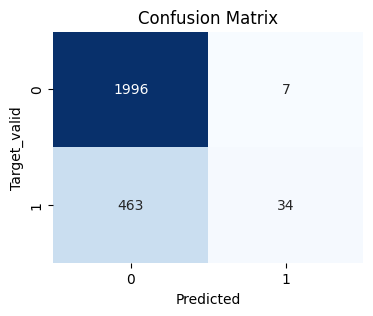

In [18]:
# Matrix de Confusion
cm = confusion_matrix(target_valid,predicted)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Target_valid')
plt.title('Confusion Matrix')
plt.show()

 Hallazgos:
 
- Como podemos ver las metricas nos indican que el modelo es lo suficiente bueno, sobre todo por F1_score y recall como explico a continuacion.
- Como vemos en la matrix de confusion tenemos verdaderos positivos, pero muchos mas verdaderos negativos.
- Para Exactitud o Accuracy, tenemos que estamos detectando el 81.2% de los valores positivos, este parametro es bueno pero no sufiente.
- Para recall o sensibilidad, tenemos que solo el 6.84% son verdaderos positivos, es decir solo este porcentaje fueron identificados correctamente.
- F1_score, es bajo 12.64% nos indica probablemente un desbalance ya que exactitud y/o recall tiene problemas.
- Auc_Roc, tenemos un 53.24%, esto nos indica que apenas y es algo mejor que un modelo al azar.

#### Mejora la calidad del modelo. Asegúrate de utilizar al menos dos enfoques para corregir el desequilibrio de clases. Utiliza conjuntos de entrenamiento y validación para encontrar el mejor modelo y el mejor conjunto de parámetros. Entrena diferentes modelos en los conjuntos de entrenamiento y validación. Encuentra el mejor. 



In [19]:
#Tenemos 2 opciones para ajustar el desequilibrio de clases el sobremuestreo o submuestreo, escogere el sobremuestreo ya que el submuestreo elimina datos y no lo considero la mejor opcion
target.value_counts() 

Exited
0    7963
1    2037
Name: count, dtype: int64

In [20]:
# Utilizaremos la libreria imblearn con RandomOverSampling para balancear las clases de forma exacta
ros = RandomOverSampler(random_state=42)
features_resampled, target_resampled = ros.fit_resample(features, target)
target_resampled.value_counts()

Exited
1    7963
0    7963
Name: count, dtype: int64

In [21]:
#Realizamos una mezcla de los datos para evitar sesgos
features_resampled, target_resampled = shuffle(features_resampled, target_resampled, random_state=42)

In [22]:
# Obtenemos nuevamente los datos de entrenamiento del modelo
features_train_res, features_valid_res, target_train_res, target_valid_res = train_test_split(features_resampled, target_resampled, random_state=42)

In [23]:
#entrenamiento del modelo
for n in range(20,40):
    model_2 = RandomForestClassifier(random_state=24, n_estimators = n, max_depth=20)
    model_2.fit(features_train_res,target_train_res)
    predicted_res = model_2.predict(features_valid_res)

    print(f'Para n_estimators {n}  -  Tenemos un exactitud:{accuracy_score(target_valid_res, predicted_res)}  -  recall: {recall_score(target_valid_res, predicted_res)}  -  F1_Score de: {f1_score(target_valid_res, predicted_res)}  -  Auc_Roc: {roc_auc_score(target_valid_res, predicted_res)}')

Para n_estimators 20  -  Tenemos un exactitud:0.7850326469111  -  recall: 0.7779495105615662  -  F1_Score de: 0.7791537667698658  -  Auc_Roc: 0.7848591256874466
Para n_estimators 21  -  Tenemos un exactitud:0.7754897036664993  -  recall: 0.7686759402369913  -  F1_Score de: 0.7694687983496648  -  Auc_Roc: 0.7753227814854726
Para n_estimators 22  -  Tenemos un exactitud:0.7812656956303365  -  recall: 0.7712519319938176  -  F1_Score de: 0.7746442432082794  -  Auc_Roc: 0.7810203804996035
Para n_estimators 23  -  Tenemos un exactitud:0.7797589151180312  -  recall: 0.7733127253992788  -  F1_Score de: 0.7739108017530292  -  Auc_Roc: 0.7796009976824909
Para n_estimators 24  -  Tenemos un exactitud:0.7822702159718734  -  recall: 0.773827923750644  -  F1_Score de: 0.7760268664427796  -  Auc_Roc: 0.7820633984260325
Para n_estimators 25  -  Tenemos un exactitud:0.7807634354595681  -  recall: 0.7697063369397218  -  F1_Score de: 0.7738927738927739  -  Auc_Roc: 0.7804925609245399
Para n_estimators 26

In [24]:
#entrenamiento del modelo
for depth in range(10,200,10):
    model_2 = RandomForestClassifier(random_state=42, n_estimators = 20, max_depth=depth)
    model_2.fit(features_train_res,target_train_res)
    predicted_res = model_2.predict(features_valid_res)

    print(f'Para depth {depth}  -  Tenemos un exactitud:{accuracy_score(target_valid_res, predicted_res)}  -  recall: {recall_score(target_valid_res, predicted_res)}  -  F1_Score de: {f1_score(target_valid_res, predicted_res)}  -  Auc_Roc: {roc_auc_score(target_valid_res, predicted_res)}')

Para depth 10  -  Tenemos un exactitud:0.7009040683073833  -  recall: 0.7161257083977332  -  F1_Score de: 0.7000755477209771  -  Auc_Roc: 0.7012769649289009
Para depth 20  -  Tenemos un exactitud:0.7722250125565042  -  recall: 0.7650695517774343  -  F1_Score de: 0.7660562290430746  -  Auc_Roc: 0.7720497195437883
Para depth 30  -  Tenemos un exactitud:0.7903063787041688  -  recall: 0.7861926841834106  -  F1_Score de: 0.7851813738101363  -  Auc_Roc: 0.7902056022582903
Para depth 40  -  Tenemos un exactitud:0.8264691109994977  -  recall: 0.8315301391035549  -  F1_Score de: 0.8236795100791018  -  Auc_Roc: 0.8265930950294844
Para depth 50  -  Tenemos un exactitud:0.8852335509794074  -  recall: 0.8938691396187533  -  F1_Score de: 0.8836261777438248  -  Auc_Roc: 0.8854451038613119
Para depth 60  -  Tenemos un exactitud:0.9113510798593671  -  recall: 0.9268418341061309  -  F1_Score de: 0.9106555302455075  -  Auc_Roc: 0.9117305691843736
Para depth 70  -  Tenemos un exactitud:0.9224008036162732 

#### Realiza la prueba final.

In [25]:
model_2 = RandomForestClassifier(random_state=42, n_estimators = 20, max_depth=40)
model_2.fit(features_train_res,target_train_res)
predicted_res = model_2.predict(features_valid_res)

print(f'Tenemos un exactitud:{accuracy_score(target_valid_res, predicted_res)}  -  recall: {recall_score(target_valid_res, predicted_res)}  -  F1_Score de: {f1_score(target_valid_res, predicted_res)}  -  Auc_Roc: {roc_auc_score(target_valid_res, predicted_res)}')

Tenemos un exactitud:0.8264691109994977  -  recall: 0.8315301391035549  -  F1_Score de: 0.8236795100791018  -  Auc_Roc: 0.8265930950294844


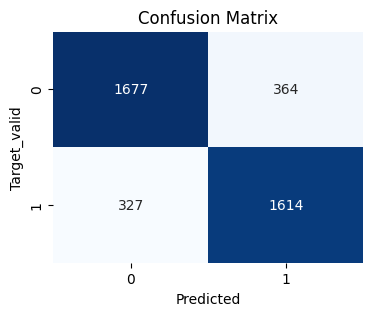

In [26]:
#Matriz de confusion con datos balanceados y modelo ajustado
cm = confusion_matrix(target_valid_res, predicted_res)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Target_valid')
plt.title('Confusion Matrix')
plt.show()

In [27]:
#Realizaremos una validacion cruzada con 5 folds

scores = cross_val_score(model_2, features_train_res, target_train_res, cv=5, scoring='accuracy')

# Imprimir los resultados
print(f"Exactitud en cada fold: {scores}")
print(f"Exactitud promedio: {np.mean(scores):.4f}")
print(f"Desviación estándar: {np.std(scores):.4f}")

Exactitud en cada fold: [0.85893679 0.81665969 0.87442445 0.85265802 0.85678392]
Exactitud promedio: 0.8519
Desviación estándar: 0.0191


#### Hallazgos

- Para la configuracion de parametros tenemos:
- El valor de n_estimators lo dejamos en 29 porque apartir de ahi no varia mucho los resultados y para evitar incrementamos en costo computacional innecesariamente podriamos escoger hasta 20.
- El valor de max_depth, tenemos un dilema, en este caso como podemos ver confirme incrementamos el valor de depth seguimos mejorando los score, y donde comienza a estabilizarse en promedio de 94%
 cuando max_depth toma el valor de 100.
- Podemos considerar 2 escenarios uno donde nos interesa optener los mejores parametros tomaremos como n_estimators = 100, y otro escenario donde queremos mantener una 
  relacion (buenos parametros)/(costo computacional) donde tomaremos n_estimators = 60.

Tenemos los siguientes resultados para el modelo con los parametros configurados:
- Como podemos ver las metricas nos indican que el modelo es lo suficiente bueno, sobre todo por F1_score y recall como explico a continuacion.
- Como vemos en la matrix de confusion tenemos verdaderos positivos en gran mayoria seguidos de Verdaderos negativos lo cual es muy bueno y muy pocos falsos positivos y  negativos.
- Para Exactitud o Accuracy, tenemos que estamos detectando el 83.77% de los valores positivos, este parametro es muy bueno.
- Para recall o sensibilidad, tenemos que solo el 83.73% son verdaderos positivos, es decir solo este porcentaje fueron identificados correctamente, este porcentaje es muy bueno.
- F1_score, es alto 83.39% nos indica que es un buen modelo y esta balanceado.
- Auc_Roc, tenemos un 83.77%, esto nos indica que el modelo es muy superio al de un modelo al azar.
- Con el resultado de la validacion cruzada comprobamos que el modelo no solo es util con un subconjunto de datos unicamente sino con las diferentes variaciones de subconjuntos.

